[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LizbethMG-Teaching/pose2behav-book/blob/main/notebooks/analysis_single-animal.ipynb)


# 📓 Notebook 2 – Analysis of single animal (top-view mouse)
## 1. Introduction & objectives

In this notebook, we will analyze pose estimation outputs generated with SuperAnimal ModelZoo on 5-minute top-view mouse video.

**Learning goals:**

- Read, understand, and visualize pose data.
- Compute simple movement metrics.
- Interpret spatial and temporal patterns scientifically.
- Communicate results using clear, reproducible visuals.
--- 
**Instructions**

This notebook mixes pre-filled code cells (nothing to change) and coding exercises that you will complete.

👉 Here’s how to work through it:
1. Read carefully each section before running the cells.
2.	When a cell requires you to code, you’ll see a TODO comment.
3.	The TODO will tell you how many lines of code you are expected to write.
4.	Write your code only between the markers:
    
```python
# >>>>>>>>>>>>>>>>>>>
# your code goes here
# <<<<<<<<<<<<<<<<<<<
```

✋ Do not edit anything outside these markers.

⚡ After finishing the course, feel free to experiment and modify the notebook as you like!

✨ Example

What you will see in the notebook:

```python
# >>>>>>>>>>>>>>>>>>>
# TODO (2 lines): compute the duration of the video and print it 
# variables: frame_count, fps
# YOUR CODE: duration = 
# YOUR CODE: print(...)
# <<<<<<<<<<<<<<<<<<< 
```

What you are expected to write: 

```python
# >>>>>>>>>>>>>>>>>>>
# TODO (2 lines): compute the duration of the video and print it 
# variables: frame_count, fps
duration = frame_count / fps
print(f"Duration (s):", duration)
# <<<<<<<<<<<<<<<<<<< 
```
---
  

<img src="https://raw.githubusercontent.com/LizbethMG-Teaching/pose2behav-book/main/assets/notebook2-cover.png" width="50%">

**Narrative**

In this notebook, you will analyze pose-estimation data from a freely-moving mouse. 

You will follow **Pixel** 🐭💛, a little mouse exploring an arena.
Using pose data captured by SuperAnimal, we’ll uncover how Pixel moves, rests, and explores. 

The goal is to transform raw x,y coordinates into quantitative descriptions of movement and space use, similar to what behavioral neuroscientists do when studying exploration and locomotion.

For this exercise you will have access to the data in form of a .h5 file that has been already pre-processed as in the previous notebook. 

This is the first frame extracted from the video: 

<img src="https://raw.githubusercontent.com/LizbethMG-Teaching/pose2behav-book/main/assets/single-frame-mouse-bedding.png" width="50%">

--- 

## 2. Data Loading & Format Inspection

### 2.1 Download data (prefilled)

**📋 Instructions:**
- Run the code cell below to download a dataset file from Google Drive (with gdown), save it locally (path depends on Colab vs local), and verify the download.

In [ ]:
# PREFILLED, NO NEED TO CHANGE, JUST RUN THIS CELL
# Install and import the required libraries:
!pip -q install gdown tables

import os
from pathlib import Path
import gdown, pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
import re
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle


# --------------------------------------------------------------

# Detect if running in Google Colab
if "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ:
    DEST = Path("/content/cleaned_pose_downloaded.h5")
else:
    DEST = Path("cleaned_pose_downloaded.h5")  # save in current folder locally
print("Saving to:", DEST)

# Select here the experiment you want to download, comment the others:
# Opt 1: Single mouse - arena without clear floor
FILE_ID = "1H-Qf8i-Y7bN4MdUT3yHyi-yVi5Aw7Emd"
# Opt 2: Single mouse - arena with bedding
# FILE_ID = 


URL = f"https://drive.google.com/uc?id={FILE_ID}"

print("Downloading from Drive...")
_ = gdown.download(URL, str(DEST), quiet=False)

# Basic checks
assert DEST.exists() and DEST.stat().st_size > 0, "❌ Download failed or empty file."
print(f"✅ Downloaded to {DEST} ({DEST.stat().st_size/1_000_000:.2f} MB)")

# --- Load the cleaned H5 file into a pandas DataFrame ---
df = pd.read_hdf(DEST, key="df_with_missing")

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:8], "...")

Saving to: cleaned_pose_downloaded.h5


Downloading...
From: https://drive.google.com/uc?id=1H-Qf8i-Y7bN4MdUT3yHyi-yVi5Aw7Emd
To: /Users/lix/Library/CloudStorage/OneDrive-Personnel/3-work/teaching/2025_BehavioralAnalysis/pose2behav-book/notebooks/cleaned_pose_downloaded.h5
100%|██████████| 5.91M/5.91M [00:01<00:00, 3.37MB/s]

✅ Downloaded to cleaned_pose_downloaded.h5 (5.91 MB)
✅ Data loaded successfully!
Shape: (9000, 81)
Columns: ['nose_x', 'nose_y', 'nose_likelihood', 'left_ear_x', 'left_ear_y', 'left_ear_likelihood', 'right_ear_x', 'right_ear_y'] ...


---

## 3. Trajectory visualization: “Following the path”

A trajectory is the mouse’s *story on the floor*: each frame adds a dot at `(x,y)`.  
By drawing dots in order (and optionally coloring by time), we see **where** and **how** it explored.

**What you’ll do:**  
1. Pick one body part (e.g., `nose`) as the **reference point**.  
2. Plot the 2D path `(x, y)` across the arena.  
3. Color the path by **time** to see exploration progress.  
4. Mark the **start** and **end** positions.

**📋 Instructions:**
- 🧩 Complete the line marked with `# TODO`
- Choose the body part (`PART = "nose"` … or another one present in your file).  
- (Optional) Flip the Y-axis if your coordinate system has origin at top-left.  
- Try a different point (e.g., `midback`, `tail_base`) and compare paths.

**Note:** This is the list of available body-parts for this dataset:

- 'nose', 'left_ear', right_ear', 'left_ear_tip', 'right_ear_tip', 'left_eye', 'right_eye'
- 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3'
- 'tail_base', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5'
- 'left_shoulder', 'left_midside', 'left_hip', 'right_shoulder', 'right_midside', 'right_hip', 'tail_end', 'head_midpoint', 'neck'


**Note 2: Coordinate conventions**

🎞️ In images and videos the coordinate origin (0, 0) is usually at the top-left corner of the frame:

- the x-axis increases → to the right
- the y-axis increases → downward

This is the standard in computer vision.

So, when you plot (x, y) the image appears upside-down compared to the original video.

🧭 Why flipping helps

- When you want your 2-D trajectory to match the arena as you see it on video:
  - Flipping the y-axis restores the natural visual orientation.
  - The mouse’s “north” (top of the screen) appears at the top of the plot again.
  - If you skip that, the path will be a mirror in the vertical direction; not wrong numerically, just visually flipped.

**Questions:**  
- Does Pixel🐭 hug the walls (thigmotaxis) or visit the center?  Why do you think is that? 
- Are there parts of the arena it avoids? Why might that be (lighting, reflections)?  
- How does the time-colored path help you see **habituation** or **search patterns**?
- If you were interested in looking at exploratory motion vs. translational what body-parts would you choose to analyze? 

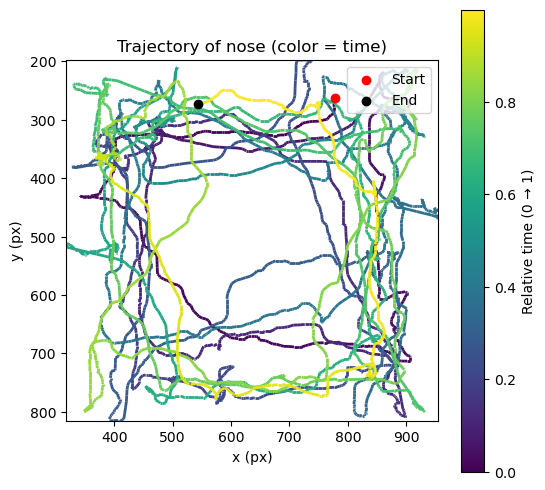

In [13]:
# === Time-colored trajectory ===

# --- Choose a bodypart to plot ---
# >>>>>>>>>>>>>>>>>>>
# TODO (1 lines): change this to experiment with another body-part (e.g., "nose", "mid_back", "tail_base")
PART = "nose"
# <<<<<<<<<<<<<<<<<<< 

# Extract x and y coordinates of the chosen bodypart as numeric arrays
x = df[f"{PART}_x"].to_numpy(dtype=float)
y = df[f"{PART}_y"].to_numpy(dtype=float)

# Keep only valid points (not NaN)
valid = ~np.isnan(x) & ~np.isnan(y)
xv, yv = x[valid], y[valid]

# Build the path segments between consecutive points
points = np.column_stack((xv, yv))
segments = np.stack([points[:-1], points[1:]], axis=1)

# Color by time (0 → start, 1 → end)
t = np.linspace(0, 1, len(xv))  # relative time from 0 to 1
lc = LineCollection(segments, array=t[:-1], cmap="viridis", linewidths=2) # color by time

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_collection(lc)

# >>>>>>>>>>>>>>>>>>>
# TODO (2 lines): mark start with a 'red' dot and 'end' wiht a black point 
# HINT: use ax.scatter() with arguments (x, y, color=..., label=..., zorder=3 ensures the points are on top of the line)
# ax.scatter( ... )  # start
# ax.scatter( ... )  # end
ax.scatter(xv[0], yv[0], color="red", label="Start", zorder=3)
ax.scatter(xv[-1], yv[-1], color="black", label="End", zorder=3)
# <<<<<<<<<<<<<<<<<<< 

# Set limits and appearance
ax.set_xlim(xv.min(), xv.max())
ax.set_ylim(yv.min(), yv.max())
ax.set_aspect("equal", adjustable="box")

#  flip y-axis if your plot looks upside-down
ax.invert_yaxis()   # <-- uncomment if needed

plt.colorbar(lc, ax=ax, label="Relative time (0 → 1)")
ax.set_title(f"Trajectory of {PART} (color = time)")
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.legend()
plt.show()


---

## 4.1 ) Spatial occupancy

Each frame gives us one point `(x, y)` = position of a body part.  
If we count how often the mouse is seen in each part of the arena,  
we get a **heatmap of time spent**:  bright = often visited, dark = rare.

This is called a **spatial occupancy map** 🗺️  
It helps answer:
- Does the mouse explore the center or stay near the walls?
- Are there favorite corners or unused areas?
  
❗ So far, our coordinates cover the **entire video frame**, but Pixel the mouse can only move inside a smaller **arena region**.  

By specifying the **arena boundaries** (the region where the mouse actually moves),  
we make the heatmap easier to read and comparable across recordings.  
Now the colors show only where Pixel really spent time 🐭🔥  

**Steps in this plot:**  
1. Define the arena limits (in pixels).  
2. Keep only points inside that region.  
3. Count how often each small cell was visited → heatmap of “time spent.”  
4. Use a log scale (`log(1 + counts)`) so even rarely visited zones remain visible.  

*📋 Instructions:**
- 🧩 Complete the line marked with `# TODO` build the 2D histogram inside the arena bounds. This will divide the arena into small spatial bins (like a grid) and each (x, y) position increases the count in the corresponding bin.

🧠 **Questions:**  
- Change BINS (e.g., 40, 120). How does detail/noise change?
- What would happen if we didn’t add the arena boundaries?: nudge X_MIN/X_MAX/Y_MIN/Y_MAX by ±20 px. Does the map shift?

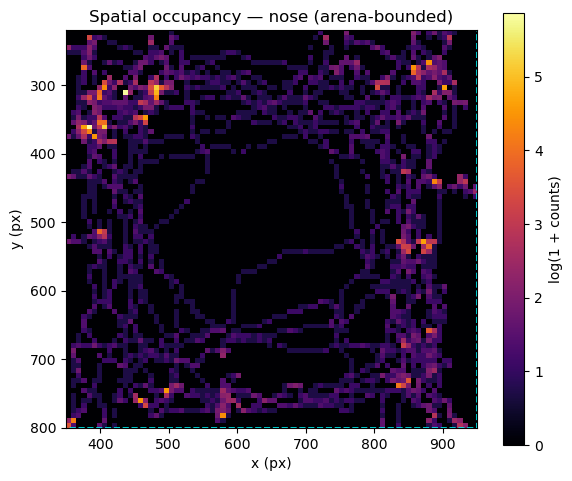

In [27]:
# === Spatial Occupancy (simple, arena-bounded) ===


# ----- Parameters to set -----
PART = "nose"          # "nose", "midback", "tail_base", etc.
BINS = 80              # 40 = coarse, 80–120 = finer
INVERT_Y = True        # True if y increases downward in your data (common in images)

# Tight arena bounds in pixels (measured once)
X_MIN, X_MAX = 350, 950
Y_MIN, Y_MAX = 220, 800

# ----- Data -----
x = df[f"{PART}_x"].to_numpy(float)
y = df[f"{PART}_y"].to_numpy(float)

valid = (~np.isnan(x)) & (~np.isnan(y))
inside = (x >= X_MIN) & (x <= X_MAX) & (y >= Y_MIN) & (y <= Y_MAX)
xv, yv = x[valid & inside], y[valid & inside]

# ----- 2D histogram within the arena -----
# >>>>>>>>>>>>>>>>>>>
# 🧩 TODO (1 line):  build the 2D histogram 
# HINT: use np.histogram2d(x, y, bins, range)
# H, xedges, yedges = np...
H, xedges, yedges = np.histogram2d(
    xv, yv, bins=BINS,
    range=[[X_MIN, X_MAX], [Y_MIN, Y_MAX]]
)
# <<<<<<<<<<<<<<<<<<< 

Z = np.log1p(H.T)  # log scale = better visibility of low counts
extent = [X_MIN, X_MAX, Y_MIN, Y_MAX]

# ----- Plot -----
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(
    Z, origin="lower", extent=extent, aspect="equal",
    cmap="inferno", interpolation="nearest"
)

# Draw the arena box for clarity
ax.add_patch(Rectangle(
    (X_MIN, Y_MIN), X_MAX - X_MIN, Y_MAX - Y_MIN,
    fill=False, edgecolor="cyan", linewidth=1.2, linestyle="--"
))

ax.set_title(f"Spatial occupancy — {PART} (arena-bounded)")
ax.set_xlabel("x (px)"); ax.set_ylabel("y (px)")
if INVERT_Y:
    ax.invert_yaxis()

plt.colorbar(im, ax=ax, label="log(1 + counts)")
plt.tight_layout()
plt.show()


Previous exercise explained: 

1. **Change BINS**
   
    What it does: controls how finely we divide the arena into spatial bins.
    - If you lower it (e.g., 40):
        → each bin covers more area → smoother, coarser heatmap → small details get lost.
    - If you raise it (e.g., 120):
        → smaller bins → sharper details but also more “salt-and-pepper” noise.

    Like image resolution, higher resolution shows more detail if data are dense enough, but can look noisy if too few samples per bin.
    
2. **Nudge arena bounds**

    What it does: shifts or resizes the rectangle defining the “valid” region of the arena.
	- Expected result: the colored heatmap moves slightly or cuts off edges, showing that your map depends on how you define the arena.
	- If the rectangle is too small, parts of the animal’s movement are cropped.
	- If it’s too large, empty borders appear dark and reduce contrast.
	- Setting precise boundaries avoids misinterpretation of where the animal actually spent time.

--- 
## 4.2 Occupancy in seconds

You might have noticed that we made the heatmap showing `log(1 + counts)` instead of a time unit. 
**Why do you think is that?**

Each square (bin) in this heatmap counts **how many video frames** the mouse was seen there.  

When we make a heatmap like this:
```
H, _, _ = np.histogram2d(x, y, bins=bins)
plt.imshow(np.log1p(H.T))
```
each cell in H = number of frames where the mouse was seen inside that spatial bin.

- If a bin was visited 3 frames → H = 3
- If it was visited 3000 frames → H = 3000

Some areas might have **thousands** of frames (the mouse stayed there a lot).  
Others might have only a few frames.  

If we plot these raw counts directly, the few “hot” bins dominate the color scale,  
and the rest of the map looks almost black.  

Taking the logarithm: `np.log1p(H)  # same as log(1 + H)`

- compresses the scale:
- keeps hotspots visible, but also lets us see faintly visited areas, giving a more balanced picture of the whole exploration.
  
👉🏼 This is a good option when you want to see patterns

### 🔢 How to express time instead of log-units ?
If we know the **frame rate (FPS)**, we can convert counts → **seconds**:

`H / FPS` : (Counts / Frames per seconds)

**📋 Instructions:**
- 🧩 Complete the nextx cell to see the result in seconds
  
Now each color directly represents the number of seconds the mouse spent in that location.

This version is better when you want quantitative measures, not just patterns.

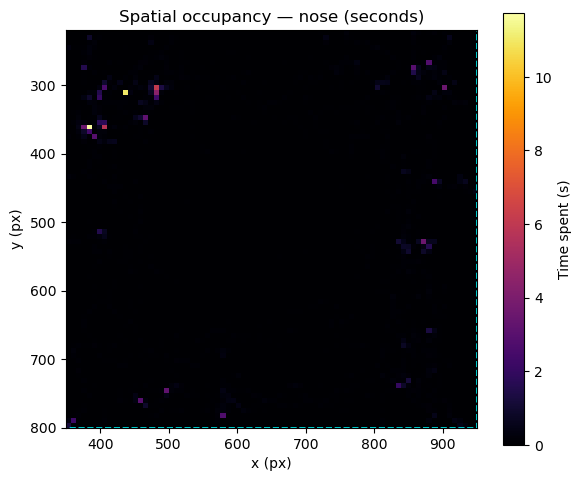

In [ ]:
# === Spatial Occupancy (in seconds) ===

FPS = 30.0   # frames per second of the video

# Each bin count = number of frames observed in that location
## >>>>>>>>>>>>>>>>>>>
# 🧩 TODO (1 line):  Convert to seconds
# H_time = ... 
H_time = H / FPS   
# <<<<<<<<<<<<<<<<<<< 
extent = [X_MIN, X_MAX, Y_MIN, Y_MAX]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(
    H_time.T, origin="lower", extent=extent, aspect="equal",
    cmap="inferno", interpolation="nearest"
)

ax.add_patch(Rectangle(
    (X_MIN, Y_MIN), X_MAX - X_MIN, Y_MAX - Y_MIN,
    fill=False, edgecolor="cyan", linewidth=1.2, linestyle="--"
))

ax.set_title(f"Spatial occupancy — {PART} (seconds)")
ax.set_xlabel("x (px)"); ax.set_ylabel("y (px)")
if INVERT_Y:
    ax.invert_yaxis()

plt.colorbar(im, ax=ax, label="Time spent (s)")
plt.tight_layout()
plt.show()

### Consistency test between video duration and data used

**📋 Instructions:**

- 🧩 Run the next cell to calculate the total duration (in seconds) represented by the heatmap.

👉🏼 What it does: 
- Each cell in the histogram H is a count of frames.
- When we sum all cells (H.sum()), we get how many frames were used in total.
- Dividing by the frame rate (FPS) converts those frame counts into seconds of video.

🧠 **Questions:** 

- What duration do you get? does it matches the total duration of the video (5 min)? 
  
    💬 **Reflection:**
    
    Even though the video lasts 5 minutes, not all frames contain valid detections inside the arena.
    The occupancy map only counts frames where the animal’s tracked point (e.g., nose) was inside the defined rectangle and not missing.
    So the total duration represented by the map can be slightly shorter; that’s expected and informative!

In [30]:
# --- Check duration consistency ---

total_frames_from_hist = H.sum()
total_time_from_hist = total_frames_from_hist / FPS

print(f"Total frames counted in histogram: {total_frames_from_hist:.0f}")
print(f"Total time covered by heatmap: {total_time_from_hist/60:.2f} min")

Total frames counted in histogram: 8654
Total time covered by heatmap: 4.81 min


---
## 5.1 Temporal dynamics: When is Pixel active?

If we look at how far a poin moves between consecutive frames, we get its **instantaneous speed**.  
- **High speed** → the mouse is **active** (moving).  
- **Low speed** → the mouse is **resting** (or nearly still).

### Formula

For each frame *t*, we have positions *(xₜ, yₜ)* in pixels.  
The speed between frames *t–1* and *t* is given by

vₜ = √((xₜ − xₜ₋₁)² + (yₜ − yₜ₋₁)²) / Δt

where:
where:
- **Δt = 1 / FPS**  → time between two frames  
- **FPS** = frames per second of the video 

**What we’ll do:**  
1. Pick a body part (e.g., `nose`) and compute **speed** over time.  
2. Choose a **threshold** to separate *active* vs. *rest*.  
3. Plot speed with the threshold line and color the **active** periods.

- The **threshold** can be chosen by intuition (e.g., 50 px/s) or **data-driven** (e.g., the 60th–80th percentile of speed).  
- Speed depends on the **frame rate (FPS)** and **pixel scale**; if you change FPS or downsample, the numbers change.  
- Optional: apply a tiny **smoothing** (rolling median) to reduce noise without hiding real movement.

*📋 Instructions:**
- 🧩 Complete the line marked with `# TODO` to compute the instantaneous speed. 
  
🧠 **Questions:**
- How does your choice of threshold change % active time?  
- Would a different body part (e.g., `mid_back` instead of `nose`) give a more stable activity signal?  
- If you knew pixels → millimeters, how would that change the interpretation?

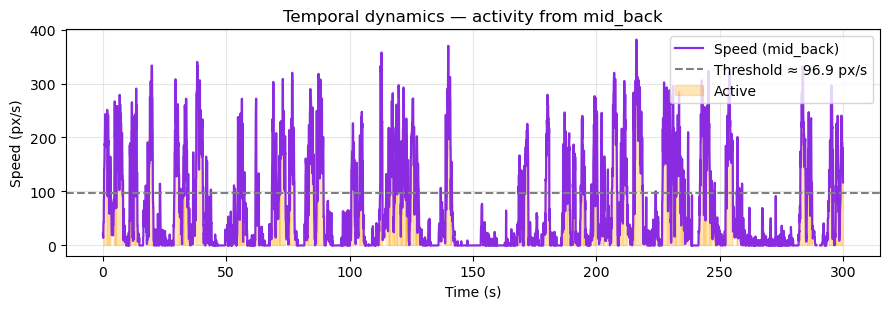

Active time: 29.9% | Estimated # bouts: 150


In [41]:
# === Temporal dynamics: speed & active bouts (simplified) ===

# --- Settings ---
PART = "mid_back"      #  pick body part (e.g., "nose", "midback", "tail_base")
FPS  = 30.0        #  et your video frame rate

# 1) Get coordinates
x = df[f"{PART}_x"].to_numpy(float)
y = df[f"{PART}_y"].to_numpy(float)

# 2) Speed (px/s) computed only where both current & previous frames are valid
valid_now  = np.isfinite(x[1:]) & np.isfinite(y[1:])
valid_prev = np.isfinite(x[:-1]) & np.isfinite(y[:-1])
vp = valid_now & valid_prev

dx = np.diff(x)
dy = np.diff(y)
## >>>>>>>>>>>>>>>>>>>
# 🧩 TODO (1 line):  Px per frame:
# HINT: use np.hypot
# speed_px_per_s = ... 
speed_px_per_s = np.hypot(dx, dy) * FPS
# <<<<<<<<<<<<<<<<<<<
speed_px_per_s[~vp] = np.nan  # ignore jumps from/into missing points

# (optional) tiny smoothing to reduce jitter
speed = pd.Series(speed_px_per_s).rolling(5, center=True, min_periods=1).median().to_numpy()

# 3) Threshold (data-driven): 70th percentile
thr = np.nanpercentile(speed, 70)
active = speed >= thr

# 4) Time axis (seconds) — note speed length is N-1
t = np.arange(speed.size) / FPS

# 5) Plot: violet speed + orange active fill
fig, ax = plt.subplots(figsize=(9, 3.2))
ax.plot(t, speed, color="#8A2BE2", lw=1.6, label=f"Speed ({PART})")     # violet
ax.axhline(thr, ls="--", color="gray", label=f"Threshold ≈ {thr:.1f} px/s")
ax.fill_between(t, 0, speed, where=active, color="#FFA500", alpha=0.28, label="Active")  # orange

ax.set_xlabel("Time (s)")
ax.set_ylabel("Speed (px/s)")
ax.set_title(f"Temporal dynamics — activity from {PART}")
ax.grid(alpha=0.3)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 6) Quick summary
pct_active = 100 * np.nanmean(active)
n_bouts = int((active & ~np.r_[False, active[:-1]]).sum())  # rising edges = bout starts
print(f"Active time: {pct_active:.1f}% | Estimated # bouts: {n_bouts}")

## 5.2 Converting to real-world units

If you know how many meters (or centimeters) correspond to one pixel,
you can convert to m/s easily with this **conversion formula**:

    **v(m/s) = v(px/s) × pixel_to_meter**

If we take for our example* a scale of:

    1 px = 0.08 cm = 0.8 mm

*This conversion is valid only for that specific camera setup (same zoom, height, and lens).

**📋 Instructions:**

- 🧩 Complete the next cell to calculate Pixel's locomotion speeds in cm/s

🧠 Questions
- Why is it useful to convert pixel speeds into real-world units?
- What extra information do you need to make this conversion accurate?
- Would the conversion factor change if you zoomed the camera or changed its angle?

💬 **Reflection:**
- Using physical units lets you compare across experiments or setups.
- A speed of “200 px/s” means little on its own, but “0.2 m/s” is immediately interpretable.
- It’s also required if you want to relate movement to biomechanics or energy use

For information: Mice locomotion speed(s) reported: 
- Exploration / slow walk : ~ 5–15 cm/s (Aydın, Ç. et al., 2018, Nat Com)
- Treadmill walking / moderate locomotion : ~ 13 – 78 cm/s (Herbin et al., 2006)
- stationary / no motion: < 2 cm/s (Gioia De Franceschi et al., 2016, Current Biology)




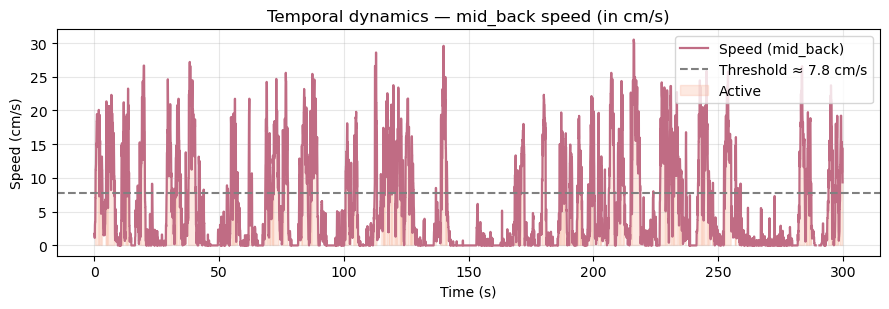

Mean speed: 5.6 cm/s
Active threshold: 7.8 cm/s


In [39]:
# === Optional: convert speed from px/s → cm/s ===

# Conversion factor: 1 px = x cm
PX_TO_CM = 0.08

# Apply conversion
speed_cm_per_s = speed * PX_TO_CM
thr_cm = thr * PX_TO_CM

# Plot again with physical units
fig, ax = plt.subplots(figsize=(9, 3.2))
ax.plot(t, speed_cm_per_s, color="#C06C84", lw=1.6, label=f"Speed ({PART})")      # cute pink
ax.axhline(thr_cm, ls="--", color="gray", label=f"Threshold ≈ {thr_cm:.1f} cm/s")
ax.fill_between(t, 0, speed_cm_per_s, where=active, color="#F8B195", alpha=0.28, label="Active")  # peach fill

ax.set_xlabel("Time (s)")
ax.set_ylabel("Speed (cm/s)")
ax.set_title(f"Temporal dynamics — {PART} speed (in cm/s)")
ax.grid(alpha=0.3)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Quick summary
print(f"Mean speed: {np.nanmean(speed_cm_per_s):.1f} cm/s")
print(f"Active threshold: {thr_cm:.1f} cm/s")

--- 
## 5 Body orientation and coordination: “Which way is the mouse facing?”

So far, we’ve looked at where the mouse goes (occupancy) and how fast it moves (speed).  

Locomotion isn’t just “moving fast or slow”; how direction changes can matter too.

Combining orientation + speed gives a richer behavioral picture.

Now, let’s see **how it orients its body** while exploring.

If we know the positions of two points: for example, the **nose** and the **tail base**
we can estimate the **body axis angle**, i.e., the direction the mouse is facing in each frame.

### Orientation formula

tail_base  →────────────→  nose

For each frame *t*, we compute he angle of the vector that starts at the tail and points to the nose:


    angleₜ = arctan2(-(y_nose - y_tail), x_nose - x_tail)

This gives angles in radians (–π to π) and then we can convert them to degrees.

- 0° → right
- 90° → down (as it appears in the video)
- 180° → left
- 270° → up

❗️in the above formula there was a catch: "-"(y_nose - y_tail)

**Do you know why we add the minus sign?**

Because in most videos (including ours),the y-axis increases downward on the screen.
    
So without the minus, when the mouse’s nose moves down in the video, the formula would think it’s turning up. 😅

Adding the "-"(y_nose - y_tail) simply flips the vertical direction so that “up, down, left, right” in your plot match what you actually see in the video.

### What it can tells us
- A **smooth change** in angle = gentle turning or scanning.  
- **Sudden large changes** = fast reorientation or sharp turns.  
- **Stable orientation** with movement = directed walking.  
- **Large variation without movement** = local exploration (sniffing, head turning).


**📋 Instructions:**

- 🧩 Complete the next cell to calculate the bbody orientation in radians


🧠 **Questions:**
- Does the mouse tend to face one side of the arena more often? 
    Directional bias could indicate lighting cues, odor traces, or asymmetrical interest in the setup.
- Are there moments where it rotates rapidly but barely moves forward?
    That suggests “in-place” activities like grooming or investigating a local spot.
- How could you relate orientation changes to speed or exploration?

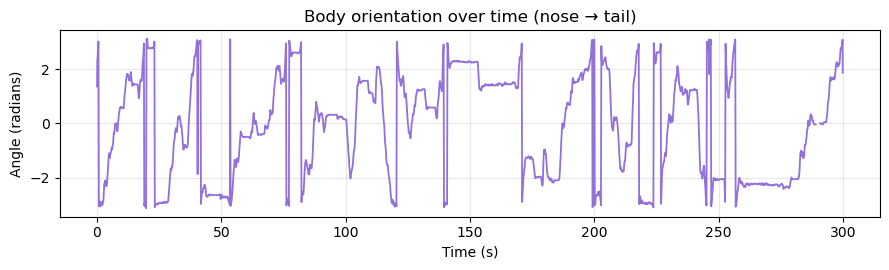

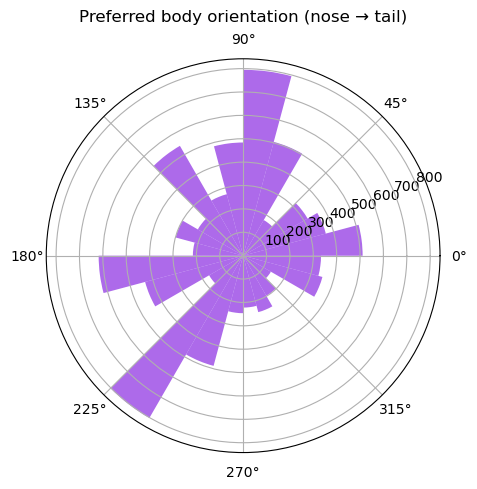

Mean orientation: -5.1°  |  Directional spread: 106.5°


In [ ]:
# === Body orientation and coordination (nose → tail) ===

# --- Choose the two keypoints defining the body axis ---
HEAD = "nose"
TAIL = "tail_base"
FPS = 30.0  # TODO: set to your video frame rate

# 1 Extract coordinates from the dataframe
xh = df[f"{HEAD}_x"].to_numpy(float)
yh = df[f"{HEAD}_y"].to_numpy(float)
xt = df[f"{TAIL}_x"].to_numpy(float)
yt = df[f"{TAIL}_y"].to_numpy(float)

## >>>>>>>>>>>>>>>>>>>
# 🧩 TODO (1 line):  2 Compute body orientation (radians)
# HINT: use np.arctan2
#angle = 
angle = np.arctan2(-(yh - yt), xh - xt)
# <<<<<<<<<<<<<<<<<<<


# 3 Optional smoothing to reduce frame-to-frame jitter
window = 5  # frames
angle_smooth = np.convolve(angle, np.ones(window)/window, mode='same')

# 4 Build time axis in seconds
t = np.arange(len(angle)) / FPS

# 5 Plot orientation over time (in seconds)
plt.figure(figsize=(9, 2.8))
plt.plot(t, angle_smooth, color="#9370DB", lw=1.3)
plt.title("Body orientation over time (nose → tail)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (radians)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 6️⃣ Polar histogram (rose plot)
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax.hist(angle, bins=24, color="#8A2BE2", alpha=0.7)
ax.set_title("Preferred body orientation (nose → tail)", va='bottom')
plt.tight_layout()
plt.show()

# 7️⃣ Quick summary statistics
mean_angle = np.degrees(np.nanmean(angle))
std_angle = np.degrees(np.nanstd(angle))
print(f"Mean orientation: {mean_angle:.1f}°  |  Directional spread: {std_angle:.1f}°")


---

## 6. Quantitative metrics summary — “From movement to numbers”

Now that we’ve explored **how** the mouse moves —  
- *where* it goes (spatial occupancy),  
- *when* it’s active (temporal dynamics), **and**  
- *how* it orients its body (body orientation and coordination) —  

we can now **summarize these behaviors** with a few key quantitative metrics.  
These give us a compact description of the mouse’s overall locomotion and exploration pattern.


### Common quantitative features
| Category | Metric | Interpretation |
|-----------|---------|----------------|
| **Activity** | % of active time | How much of the session the mouse was moving (vs resting) |
| **Speed** | Mean / median / max speed | General locomotion level and peaks |
| **Spatial** | Arena coverage (%) | How much of the arena surface was explored |
| **Orientation** | Mean angle / angular variability | Whether the mouse tends to face a preferred direction or frequently reorients |
| **Behavioral rhythm** | Number of active bouts | How fragmented the activity is (many short bouts vs. long continuous movement) |


**📋 Instructions:**
- We will reuse the variables calculated in the previous steps to create a short quantitative summary.
- 🧩 Just run the next cell — the hard work (cleaning, speed, and orientation computation) has already been done.


🧠 **Questions:**
- How would these metrics differ between the arena **with bedding** vs **without**?  
- What could cause *high speed but low coverage*?  
- Do mice with **more turning variability** necessarily explore more?  
- Could low likelihoods or tracking gaps bias the computed metrics?  

---

In [ ]:
# === Quantitative Metrics Summary (one-shot) ===

# -------------------------
# 0) Graceful fallbacks
# -------------------------
# Expecting these from earlier cells: speed_cm_per_s, active, FPS, xv, yv, X_MIN, X_MAX, Y_MIN, Y_MAX, angle
# If any are missing, we try to rebuild minimal versions.

# FPS
try:
    FPS
except NameError:
    FPS = 30.0

# Speed (cm/s): try to use existing; else compute quickly from nose
if "speed_cm_per_s" not in globals():
    PART = "nose"
    x = df[f"{PART}_x"].to_numpy(float)
    y = df[f"{PART}_y"].to_numpy(float)
    valid_now  = np.isfinite(x[1:]) & np.isfinite(y[1:])
    valid_prev = np.isfinite(x[:-1]) & np.isfinite(y[:-1])
    vp = valid_now & valid_prev
    dx, dy = np.diff(x), np.diff(y)
    speed_px_per_s = np.hypot(dx, dy) * FPS
    speed_px_per_s[~vp] = np.nan
    PX_TO_CM = 0.08
    speed_cm_per_s = speed_px_per_s * PX_TO_CM

# Active mask: try to use existing; else percentile threshold (70th)
if "active" not in globals():
    thr = np.nanpercentile(speed_cm_per_s, 70)
    active = speed_cm_per_s >= thr

# Valid positions inside arena for coverage
if not all(k in globals() for k in ["xv", "yv"]):
    PART = "nose"
    X_MIN, X_MAX = globals().get("X_MIN", 300), globals().get("X_MAX", 1000)
    Y_MIN, Y_MAX = globals().get("Y_MIN", 200), globals().get("Y_MAX", 900)
    x = df[f"{PART}_x"].to_numpy(float)
    y = df[f"{PART}_y"].to_numpy(float)
    valid = np.isfinite(x) & np.isfinite(y)
    inside = (x >= X_MIN) & (x <= X_MAX) & (y >= Y_MIN) & (y <= Y_MAX)
    mask = valid & inside
    xv, yv = x[mask], y[mask]

# Orientation angle (radians): try to use existing; else compute (nose → tail_base), video-friendly (flip y)
if "angle" not in globals():
    HEAD, TAIL = "nose", "tail_base"
    xh, yh = df[f"{HEAD}_x"].to_numpy(float), df[f"{HEAD}_y"].to_numpy(float)
    xt, yt = df[f"{TAIL}_x"].to_numpy(float), df[f"{TAIL}_y"].to_numpy(float)
    angle = np.arctan2(-(yh - yt), (xh - xt))  # minus for video y-down

# -------------------------
# 1) Activity metrics
# -------------------------
pct_active = float(100 * np.nanmean(active))
# Bout starts = rising edges
bout_starts = (active & ~np.r_[False, active[:-1]])
n_bouts = int(np.nansum(bout_starts))

# -------------------------
# 2) Speed metrics (cm/s)
# -------------------------
mean_speed   = float(np.nanmean(speed_cm_per_s))
median_speed = float(np.nanmedian(speed_cm_per_s))
max_speed    = float(np.nanmax(speed_cm_per_s))

# -------------------------
# 3) Spatial coverage (% bins visited at least once)
# -------------------------
bins = 60  # TODO: try 40 (coarser) or 100 (finer)
H, _, _ = np.histogram2d(
    xv, yv, bins=bins,
    range=[[X_MIN, X_MAX], [Y_MIN, Y_MAX]]
)
coverage = float(100 * (np.count_nonzero(H) / H.size))

# -------------------------
# 4) Orientation metrics
# -------------------------
angle_deg = np.degrees(angle)
# Angular speed (deg/s) from unwrapped angles to avoid 180/-180 jumps
ang_speed_deg_s = np.degrees(np.diff(np.unwrap(angle))) * FPS
mean_angle_deg  = float(np.nanmean(angle_deg))
std_angle_deg   = float(np.nanstd(angle_deg))
mean_ang_speed  = float(np.nanmean(ang_speed_deg_s))

# -------------------------
# 5) Session duration (min)
# -------------------------
session_minutes = float(len(speed_cm_per_s) / FPS / 60.0)

# -------------------------
# 6) Print a tidy report
# -------------------------
print("=== Quantitative Metrics Summary ===")
print(f"Session duration:     {session_minutes:.1f} min")
print(f"Active time:          {pct_active:.1f}%")
print(f"Number of bouts:      {n_bouts}")
print(f"Mean speed:           {mean_speed:.1f} cm/s")
print(f"Median speed:         {median_speed:.1f} cm/s")
print(f"Max speed:            {max_speed:.1f} cm/s")
print(f"Arena coverage:       {coverage:.1f}%")
print(f"Mean orientation:     {mean_angle_deg:.1f}°")
print(f"Orientation spread:   {std_angle_deg:.1f}°  (std)")
print(f"Mean angular speed:   {mean_ang_speed:.1f} °/s")


=== Quantitative Metrics Summary ===
Session duration:     5.0 min
Active time:          29.9%
Number of bouts:      150
Mean speed:           5.6 cm/s
Median speed:         1.8 cm/s
Max speed:            30.5 cm/s
Arena coverage:       45.7%
Mean orientation:     -5.1°
Orientation spread:   106.5°  (std)
Mean angular speed:   5.8 °/s


---

## 7. 🎥 Fun Bonus: short animation

Now that we’ve cleaned and explored the data, let’s visualize how the tracked body parts move over time.
This simple animation connects key points; nose, ears, mid-back, and tail-base to form a “stick-mouse”.

Each frame shows the mouse’s pose at a given moment, and the nose trail leaves a short path of recent movement.

How it works

1.	Extract the (x, y) coordinates for each selected body part.
2.	Keep only frames where coordinates are valid (not NaN).
3.	Subsample and limit to 10 seconds for faster playback.
4.	Draw:
-   Dots → each body part (colored by type)
-   Lines → connections forming the stick figure
-   A violet trail → recent positions of the nose

🧩 Instructions: Try it yourself
- Change PARTS to include or remove body parts (e.g. add "tail_tip" if available).
- Adjust STEP or DURATION_S to make it smoother or longer.
- Uncomment ax.invert_yaxis() if the animation looks flipped.

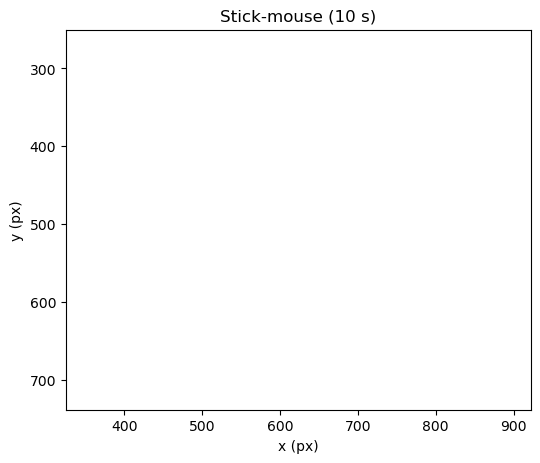

In [63]:
# === Short stick-figure animation (5 parts) ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')  # show inline

# --- Settings ---
FPS = 30.0          # frames per second
DURATION_S = 10     # animate first 10 s
STEP = 2            # use every Nth frame to speed up
TRAIL = 25          # frames of nose trail

PARTS = ["nose", "left_ear", "right_ear", "mid_back", "tail_base"]
COLORS = {"nose":"#8A2BE2","left_ear":"#7FDBFF","right_ear":"#7FDBFF",
          "mid_back":"#00BFA6","tail_base":"#FF7F0E"}
EDGES = [("tail_base","mid_back"),
         ("mid_back","left_ear"), ("left_ear","nose"),
         ("mid_back","right_ear"), ("right_ear","nose")]

# --- Load coords (assumes columns like 'nose_x', 'mid_back_y', etc.) ---
def xy(name):
    return df[f"{name}_x"].to_numpy(float), df[f"{name}_y"].to_numpy(float)

data = {p: xy(p) for p in PARTS if f"{p}_x" in df.columns and f"{p}_y" in df.columns}
assert set(PARTS).issubset(set(data)), "Missing columns for one of: " + ", ".join(PARTS)

# Keep frames where at least nose & tail_base are finite (simple, robust)
valid = np.isfinite(data["nose"][0]) & np.isfinite(data["nose"][1]) & \
        np.isfinite(data["tail_base"][0]) & np.isfinite(data["tail_base"][1])

# Slice to 10 s and subsample
max_frames = int(DURATION_S * FPS)
for p in PARTS:
    x, y = data[p]
    data[p] = (x[valid][:max_frames:STEP], y[valid][:max_frames:STEP])

T = min(len(data[p][0]) for p in PARTS)
for p in PARTS:  # align lengths
    data[p] = (data[p][0][:T], data[p][1][:T])

# Axes limits from data (with small margins)
allx = np.concatenate([data[p][0] for p in PARTS])
ally = np.concatenate([data[p][1] for p in PARTS])
x1, x2 = np.nanpercentile(allx, [1, 99]); y1, y2 = np.nanpercentile(ally, [1, 99])
mx, my = 0.05*(x2-x1+1), 0.05*(y2-y1+1)

# --- Figure ---
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(x1-mx, x2+mx); ax.set_ylim(y1-my, y2+my)
ax.set_aspect("equal", adjustable="box")
ax.set_title("Stick-mouse (10 s)")
ax.set_xlabel("x (px)"); ax.set_ylabel("y (px)")
ax.invert_yaxis()  # match video coords (y down)

# Points (initialize at zeros, then update)
pts_order = PARTS
colors = [COLORS[p] for p in pts_order]
sc = ax.scatter([0]*len(pts_order), [0]*len(pts_order), s=40, c=colors, zorder=3)

# Edges (one line per connection)
edge_lines = []
for a,b in EDGES:
    ln, = ax.plot([], [], lw=2.5, color="#444", alpha=0.9, zorder=2)
    edge_lines.append((ln, a, b))

# Nose trail
trail, = ax.plot([], [], lw=2, alpha=0.6, color=COLORS["nose"], zorder=1)

# --- Anim funcs ---
def frame_coords(i):
    return {p: (data[p][0][i], data[p][1][i]) for p in PARTS}

def init():
    sc.set_offsets(np.zeros((len(pts_order),2)))
    for ln,_,_ in edge_lines: ln.set_data([], [])
    trail.set_data([], [])
    return (sc, *(ln for ln,_,_ in edge_lines), trail)

def update(i):
    pts = frame_coords(i)
    arr = np.array([[pts[p][0], pts[p][1]] for p in pts_order])
    sc.set_offsets(arr)

    for ln,a,b in edge_lines:
        xa,ya = pts[a]; xb,yb = pts[b]
        if np.isfinite(xa) and np.isfinite(ya) and np.isfinite(xb) and np.isfinite(yb):
            ln.set_data([xa, xb], [ya, yb])
        else:
            ln.set_data([], [])

    # nose trail (last TRAIL frames)
    j0 = max(0, i-TRAIL)
    xn, yn = data["nose"]
    trail.set_data(xn[j0:i+1], yn[j0:i+1])
    return (sc, *(ln for ln,_,_ in edge_lines), trail)

interval_ms = int(1000 * STEP / FPS)
anim = FuncAnimation(fig, update, frames=T, init_func=init,
                     interval=interval_ms, blit=False, repeat=False)
anim